# Comparing datasets

In [1]:
import os; from os import listdir; from os.path import isfile, join
import re  
#from skimage import io 
from skimage.io import imread
# To manipulate arrays
import numpy as np 
import random
from tqdm.notebook import tqdm
from timeit import default_timer as timer
import scipy
import pandas as pd
import shutil
import pathlib
import sys
# Plotting
import matplotlib as mpl ; import matplotlib.pyplot as plt 
# To create interactive elements
import ipywidgets as widgets ; from ipywidgets import interact, interactive, fixed, interact_manual, Button, HBox, VBox, Layout, GridspecLayout ; from IPython.display import Image

In [2]:
# Deffining directories
current_dir = pathlib.Path().absolute()
sequences_dir = current_dir.parents[1].joinpath('DataBases','gene_files')
video_dir = current_dir.parents[1].joinpath('DataBases','videos_for_sim_cell')
trajectiories_dir = current_dir.parents[1].joinpath('DataBases','rsnapsim_simulations','bactin_ssa.npy')
rsnaped_dir = current_dir.parents[1].joinpath('rsnaped')

In [3]:
# Importing rSNAPsim_IP
sys.path.append(str(rsnaped_dir))
import rsnaped as rsp

In [4]:
# These are the parameters that need to be tested. 
number_of_simulated_cells = 1  # PLEASE TEST MIN 1 MAX 10
number_spots_per_cell = 50     # PLEASE TEST MIN 5 MAX 200
simulation_time_in_sec = 100     # PLEASE TEST MIN 10 MAX 100
diffusion_coefficient = 0.56    # PLEASE TEST MIN 0.1 MAX 2

In [5]:
intensity_calculation_method = 'disk_donut'  # options are : 'total_intensity' and 'disk_donut' 'gaussian_fit'
mask_selection_method = 'max_area' # options are : 'max_spots' and 'max_area' 
use_optimization_for_tracking = 0 # 0 not using, 1 is using optimization
frame_selection_empty_video = 'shuffle' # Options are: 'constant' , 'shuffle' and 'loop'

In [6]:
particle_size = 5 # spot size for the simulation and tracking.
elongation_rate = 3
initiation_rate = 0.03

In [7]:
def fun_simulated_cells(current_dir,trajectiories_dir, video_dir,number_of_simulated_cells=3,number_spots_per_cell=80,simulation_time_in_sec =100,step_size_in_sec=1,particle_size=5, diffusion_coefficient =1, path_to_save_output='temp',intensity_calculation_method='gaussian_fit',frame_selection_empty_video=frame_selection_empty_video):
    spot_size = particle_size
    spot_sigma = 2
    # Code that creates the folder to store results.
    diffusion_coefficient_string = str(diffusion_coefficient).replace('.','_')
    
    directory_name = 'Simulation_V2__'+'ns_'+str(number_spots_per_cell) +'_diff_'+ diffusion_coefficient_string 
    path_to_save_output = 'temp'
    save_to_path =  current_dir.joinpath(path_to_save_output , directory_name )
    
    if not os.path.exists(str(save_to_path)):
        os.makedirs(str(save_to_path))
    else:
        shutil.rmtree(str(save_to_path))
        os.makedirs(str(save_to_path))
        
    # Loading trajectories from file
    ssa_trajectories = np.load(str(trajectiories_dir))
    counter = 0
    ## Main loop that creates each cell and dataframe
    for cell_number in range (0, number_of_simulated_cells):
        ouput_directory_name = str(video_dir)
        list_files_names = sorted([f for f in listdir(ouput_directory_name) if isfile(join(ouput_directory_name, f)) and ('.tif') in f], key=str.lower)  # reading all tif files in the folder
        list_files_names.sort(key=lambda f: int(re.sub('\D', '', f)))  # sorting the index in numerical order
        path_files = [ str(video_dir.joinpath(f).resolve()) for f in list_files_names ] # creating the complete path for each file
        video_path = path_files[counter]        
        video = imread(video_path) 
        counter +=1
        if counter>=len(path_files):
            counter =0
        random_index_ch1 = np.random.randint(low=0, high=ssa_trajectories.shape[0]-1, size=(number_spots_per_cell,))
        random_index_ch2 = np.random.randint(low=0, high=ssa_trajectories.shape[0]-1, size=(number_spots_per_cell,))
        simulated_trajectories_ch1 = ssa_trajectories[random_index_ch1,0:simulation_time_in_sec:step_size_in_sec]
        simulated_trajectories_ch2 =  ssa_trajectories[random_index_ch2,0:simulation_time_in_sec:step_size_in_sec]
        # Running the cell simulation
        saved_file_name = str(save_to_path.joinpath('sim_cell_'+str(cell_number)))
        tensor_video , tensor_for_image_j , spot_positions_movement, tensor_mean_intensity_in_figure, tensor_std_intensity_in_figure, DataFrame_particles_intensities = rsp.SimulatedCell( base_video=video, number_spots = number_spots_per_cell, number_frames=simulation_time_in_sec, step_size=step_size_in_sec, diffusion_coefficient =diffusion_coefficient, simulated_trajectories_ch0=None, size_spot_ch0=spot_size, spot_sigma_ch0=spot_sigma, simulated_trajectories_ch1=simulated_trajectories_ch1, size_spot_ch1=spot_size, spot_sigma_ch1=spot_sigma, simulated_trajectories_ch2=simulated_trajectories_ch2, size_spot_ch2=spot_size, spot_sigma_ch2=spot_sigma, ignore_ch0=0,ignore_ch1=0, ignore_ch2=1,save_as_tif_uint8=0,save_as_tif =1,save_as_gif=0, save_dataframe=1, saved_file_name=saved_file_name,create_temp_folder = False, intensity_calculation_method=intensity_calculation_method,perform_video_augmentation=1,frame_selection_empty_video=frame_selection_empty_video).make_simulation()      
        #print ('The results are saved in folder: ', saved_file_name)
    return save_to_path

In [8]:
ouput_directory_name = fun_simulated_cells(current_dir,trajectiories_dir,video_dir,number_of_simulated_cells=number_of_simulated_cells,number_spots_per_cell=number_spots_per_cell,simulation_time_in_sec =simulation_time_in_sec,step_size_in_sec=1,particle_size=particle_size, diffusion_coefficient=diffusion_coefficient,intensity_calculation_method=intensity_calculation_method,frame_selection_empty_video=frame_selection_empty_video)

In [9]:
# Reads the folder with the results and import the simulations as lists
list_files_names = sorted([f for f in listdir(ouput_directory_name) if isfile(join(ouput_directory_name, f)) and ('.tif') in f], key=str.lower)  # reading all tif files in the folder
list_files_names.sort(key=lambda f: int(re.sub('\D', '', f)))  # sorting the index in numerical order
path_files = [ str(ouput_directory_name.joinpath(f).resolve()) for f in list_files_names ] # creating the complete path for each file

# Reading the microscopy data
list_videos = [imread(f)[:,:,:,:] for f in  path_files] # List with all the videos
nimg = number_of_simulated_cells

In [10]:
# Reads the dataframes
list_files_dfnames = sorted([f for f in listdir(ouput_directory_name) if isfile(join(ouput_directory_name, f)) and ('.csv') in f], key=str.lower)  # reading all tif files in the folder
list_files_dfnames.sort(key=lambda f: int(re.sub('\D', '', f)))  # sorting the index in numerical order
path_files_df = [ str(ouput_directory_name.joinpath(f).resolve()) for f in list_files_dfnames ] # creating the complete path for each file
list_df_real_positions = [pd.read_csv(f) for f in  path_files_df] # List with all the dataframes

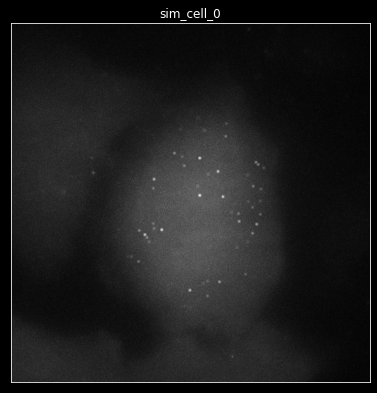

In [11]:
rsp.VisualizerImage(list_videos,list_files_names=list_files_names,selected_channel =0,selected_timepoint= 0,normalize=0,individual_figure_size=7).plot()

  0%|          | 0/1 [00:00<?, ?it/s]

mask time: 12  sec
tracking time: 5  sec
intensity calculation time: 10  sec


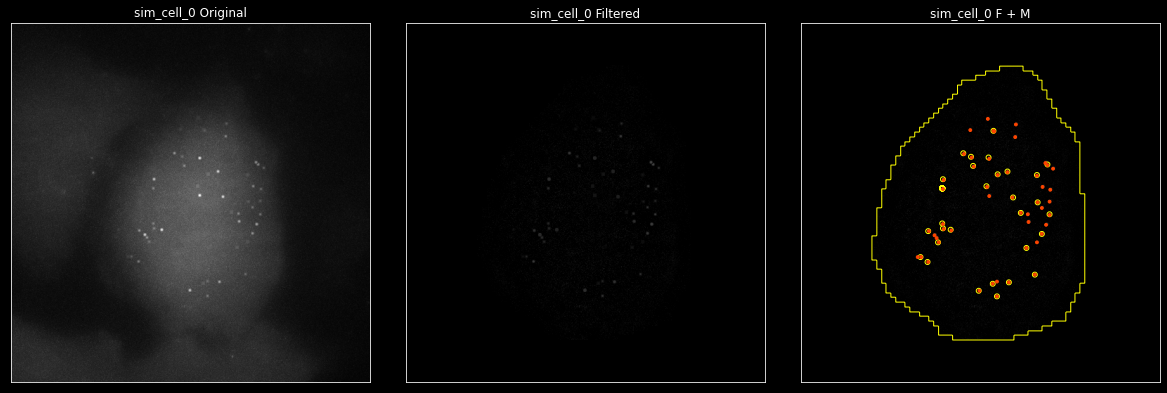

In [12]:
#intensity_selection_method =intensity_selection_method, mask_selection_method = mask_selection_method
list_DataFrame_particles_intensities= []
list_array_intensities = []
list_time_vector = []
for i in tqdm(range(0,nimg)): 
    DataFrame_particles_intensities, array_intensities, time_vector, mean_intensities,std_intensities, mean_intensities_normalized, std_intensities_normalized = rsp.PipelineTracking(list_videos[i],particle_size=particle_size,file_name=list_files_names[i],selected_channel=0,intensity_calculation_method =intensity_calculation_method, mask_selection_method = mask_selection_method,show_plot=1,use_optimization_for_tracking=use_optimization_for_tracking,real_positions_dataframe = list_df_real_positions[i],average_cell_diameter=200,print_process_times=1).run()    
    list_DataFrame_particles_intensities.append(DataFrame_particles_intensities)
    list_array_intensities.append(array_intensities)
    list_time_vector.append(time_vector)

In [13]:
# Dataframe from simulated data
num_particles_real = list_df_real_positions[0]['particle'].nunique()
print('number of particles:', num_particles_real , '\n')
list_df_real_positions[0]

number of particles: 50 



,Unnamed: 0,cell_number,particle,frame,red_int_mean,green_int_mean,blue_int_mean,red_int_std,green_int_std,blue_int_std,x,y
0,0,0,0,0,282.0,838.0,0.0,19.595918,200.726297,0.0,265.0,233.0
1,1,0,0,1,619.0,846.5,0.0,113.774514,202.610957,0.0,265.0,235.0
2,2,0,0,2,1062.5,864.5,0.0,286.820351,215.457927,0.0,266.0,235.0
3,3,0,0,3,813.0,869.5,0.0,202.511606,216.447315,0.0,265.0,236.0
4,4,0,0,4,321.5,887.5,0.0,28.022163,223.965726,0.0,265.0,236.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4995,0,49,95,994.5,345.0,0.0,265.827926,47.581509,0.0,319.0,274.0
4996,4996,0,49,96,594.0,348.0,0.0,140.886337,47.736343,0.0,319.0,274.0
4997,4997,0,49,97,753.0,342.0,0.0,197.607708,47.581509,0.0,319.0,274.0
4998,4998,0,49,98,1077.0,329.5,0.0,284.977798,46.411309,0.0,321.0,274.0


In [14]:
# Dataframe from tracking
num_particles_tracking = list_DataFrame_particles_intensities[0]['particle'].nunique()
print('number of particles:',num_particles_tracking, '\n')
list_DataFrame_particles_intensities[0]

number of particles: 51 



,cell_number,particle,frame,red_int_mean,green_int_mean,blue_int_mean,red_int_std,green_int_std,blue_int_std,x,y
0,0,0,0,608.5,207.5,0.0,180.807938,48.759885,0.0,354.020123,272.997713
1,0,0,2,174.0,197.0,0.0,66.031677,58.881359,0.0,353.022817,272.998689
2,0,0,3,547.0,218.5,0.0,164.724963,62.738824,0.0,353.614440,271.998736
3,0,0,4,923.5,221.0,0.0,279.270696,50.756895,0.0,353.021620,271.997497
4,0,0,5,624.0,232.5,0.0,208.249212,67.761771,0.0,354.020049,271.999109
...,...,...,...,...,...,...,...,...,...,...,...
3524,0,50,95,158.0,36.5,0.0,66.902604,32.476798,0.0,207.171952,317.003089
3525,0,50,96,180.0,123.0,0.0,70.821511,44.493703,0.0,207.292267,314.683486
3526,0,50,97,325.0,113.0,0.0,91.389417,50.251941,0.0,207.368813,314.621883
3527,0,50,98,180.5,120.0,0.0,75.628820,60.191029,0.0,207.346902,314.627522


In [15]:
# https://stackoverflow.com/questions/31667070/max-distance-between-2-points-in-a-data-set-and-identifying-the-points/31667270#31667270
# https://stackoverflow.com/questions/31632190/measuring-geographic-distance-with-scipy
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy.spatial.distance.pdist

## Metric to calculate the distance between trajectories

In [16]:
# https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.103.2617&rep=rep1&type=pdf

Euclidean distance is used to calculate the distance between each point

$d=(x_2−x_1)^2+(y_2−y_1)^2$

Average

$\mu(di) = \frac{1}{n} \sum\limits_{i=1}^n = d_i$

Standard deviation

$\sigma = \sqrt{\frac{1}{N} \sum_{i=1}^N (x_i - \mu)^2},\text{ where } \mu = \frac{1}{N} \sum_{i=1}^N x_i$

Standard error of the sample mean

$SEM = \frac{\sigma_{x}}{\sqrt{N}}$

In [17]:
import itertools
from scipy.spatial.distance import pdist
from scipy import stats

df_sim = list_df_real_positions[0]
df_tracking = list_DataFrame_particles_intensities[0]

list_idx_sim = np.arange(0,num_particles_real,step=1)
list_idx_tracking = np.arange(0,num_particles_tracking,step=1)

distance_matrix_mean = np.zeros(( len(list_idx_sim),len(list_idx_tracking)))
distance_matrix_sem = np.zeros(( len(list_idx_sim),len(list_idx_tracking)))

# Loop that iterates for all trajectory combinations
for index_sim, index_tracking in itertools.product(list_idx_sim,list_idx_tracking):
    time_df_tracking = df_tracking.loc[df_tracking['particle']==index_tracking].frame.values[:]
    temp_distance_matrix = []
    # Loop that iterates for the length of the tracking trajectory
    for index_time in time_df_tracking:
        # coordinates simulation
        #print(index_sim,index_time)
        x_val_sim = df_sim.loc[(df_sim['particle']==index_sim) & (df_sim['frame']==index_time)].x.values[0]
        y_val_sim = df_sim.loc[(df_sim['particle']==index_sim) & (df_sim['frame']==index_time)].y.values[0]
        # coordinates tracking
        x_val_tracking = df_tracking.loc[(df_tracking['particle']==index_tracking) & (df_tracking['frame']==index_time)].x.values[0]
        y_val_tracking = df_tracking.loc[(df_tracking['particle']==index_tracking) & (df_tracking['frame']==index_time)].y.values[0]        
        # Combining coordinates between simulation and tracking
        coordinates_sim = [x_val_sim,y_val_sim]
        coordinates_tracking = [x_val_tracking,y_val_tracking]
        matrix_coordinates = [coordinates_sim, coordinates_tracking] 
        # Calculating the Euclidean distance
        temp_distance_matrix.append( np.round(pdist(matrix_coordinates, 'euclidean'),2) )
    # Saving comparison in a numpy array
    distance_matrix_mean[index_sim, index_tracking] = np.mean(temp_distance_matrix)
    distance_matrix_sem[index_sim, index_tracking] = stats.sem(temp_distance_matrix, axis=None)

In [18]:
distance_matrix_mean.shape

(50, 51)

In [19]:
print(len(list_idx_sim),len(list_idx_tracking))

50 51


In [20]:
# Selecting the closest trajectories
min_distances = np.amin (distance_matrix_mean,axis =0)
print(np.round(min_distances,1))

[0.7 0.7 0.7 0.7 0.4 0.9 1.1 0.3 0.3 0.5 1.4 0.6 0.4 0.5 0.6 0.4 1.6 0.7
 0.5 0.7 0.6 0.8 0.7 0.9 0.9 1.  0.4 1.  1.2 0.7 0.5 0.4 0.1 0.7 0.4 3.2
 0.1 2.7 0.6 0.1 1.1 0.5 0.6 0.2 3.7 0.2 1.5 0.5 0.6 0.3 0.7]


In [21]:
# Selecting the closest trajectories
min_distances = np.amin (distance_matrix_sem,axis =0)
print(np.round(min_distances,1))

[0.2 0.  0.1 0.  0.  0.1 0.2 0.1 0.1 0.  0.2 0.  0.  0.  0.1 0.  0.2 0.1
 0.  0.  0.  0.2 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.  0.  0.  0.1 0.  0.2
 0.  0.3 0.  0.  0.2 0.1 0.1 0.  0.3 0.  0.2 0.1 0.1 0.1 0.1]


In [22]:
# making pairs if the distance is shorter than a treshold
min_distances = np.amin (distance_matrix_mean,axis =0)
min_index_distances = np.argmin (distance_matrix_mean,axis =0)
pairs = []
false_detection = []
treshold_mean = 2
list_selected_trajectories =[]

# loop that detect paired trajectories and false trajectories
for i in list_idx_tracking:
    if min_distances[i] < treshold_mean:
        pairs.append([min_index_distances[i],i])
        list_selected_trajectories.append(i)
    else:
        false_detection.append(i)

In [23]:
print(pairs)

[[11, 0], [12, 1], [38, 2], [31, 3], [43, 4], [30, 5], [14, 6], [47, 7], [19, 8], [25, 9], [35, 10], [4, 11], [15, 12], [44, 13], [9, 14], [3, 15], [5, 16], [8, 17], [41, 18], [42, 19], [17, 20], [26, 21], [45, 22], [1, 23], [33, 24], [10, 25], [24, 26], [16, 27], [0, 28], [27, 29], [22, 30], [36, 31], [37, 32], [21, 33], [2, 34], [29, 36], [48, 38], [23, 39], [49, 40], [13, 41], [39, 42], [18, 43], [20, 45], [47, 46], [9, 47], [30, 48], [19, 49], [21, 50]]


In [24]:
print(false_detection)

[35, 37, 44]


In [36]:
print(list_selected_trajectories)
fragmented_trejectories =  [list_selected_trajectories[i] for i in range(len(list_selected_trajectories)) if list_selected_trajectories[i] in list_selected_trajectories[:i]][1:]
fragmented_trejectories

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50]


[]

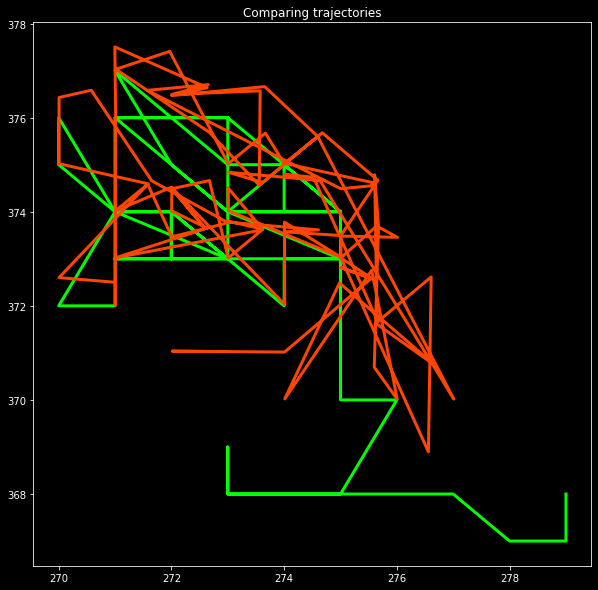

In [28]:
selected_pair = 10

# coordinates tracking
x_val_sim = df_sim.loc[df_sim['particle']==pairs[selected_pair][0] ].x.values[:]
y_val_sim = df_sim.loc[df_sim['particle']==pairs[selected_pair][0] ].y.values[:]

x_val_tracking = df_tracking.loc[df_tracking['particle']==pairs[selected_pair][1] ].x.values[:]
y_val_tracking = df_tracking.loc[df_tracking['particle']==pairs[selected_pair][1] ].y.values[:]   

plt.figure(figsize=(10,10))
plt.plot(x_val_sim,y_val_sim, '-',linewidth = 3,color='lime');
plt.plot(x_val_tracking,y_val_tracking, '-',linewidth = 3,color='orangered');

plt.title('Comparing trajectories')
plt.show()

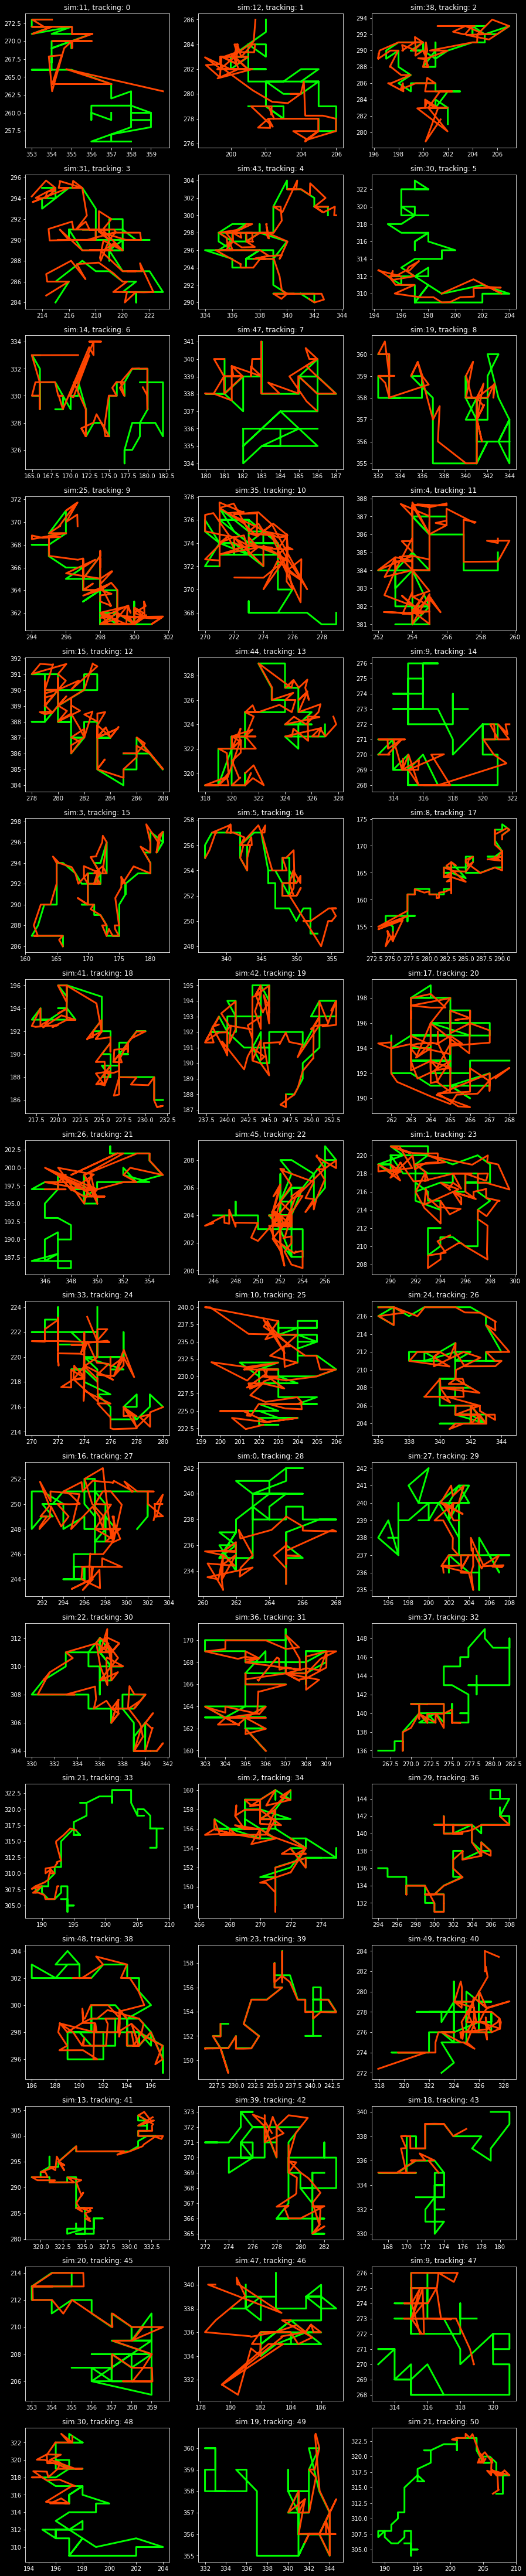

In [37]:
import math
from matplotlib import gridspec

NUM_COLUMNS =3
NUM_PLOTS = len(pairs)
NUM_ROWS = int(math.ceil(NUM_PLOTS/ NUM_COLUMNS))
FIGURE_SIZE = 5

# Loop to plot multiple cells in a grid
gs = gridspec.GridSpec(NUM_ROWS, NUM_COLUMNS)
gs.update(wspace=0.2, hspace=0.2) # set the spacing between axes.
fig = plt.figure(figsize=(FIGURE_SIZE*NUM_COLUMNS, FIGURE_SIZE*NUM_ROWS))
for i in range(0,NUM_PLOTS):    
    
    # coordinates tracking
    x_val_sim = df_sim.loc[df_sim['particle']==pairs[i][0] ].x.values[:]
    y_val_sim = df_sim.loc[df_sim['particle']==pairs[i][0] ].y.values[:]
    x_val_tracking = df_tracking.loc[df_tracking['particle']==pairs[i][1] ].x.values[:]
    y_val_tracking = df_tracking.loc[df_tracking['particle']==pairs[i][1] ].y.values[:]   

    ax = fig.add_subplot(gs[i])
    ax.plot(x_val_sim,y_val_sim, '-',linewidth = 3,color='lime');
    ax.plot(x_val_tracking,y_val_tracking, '-',linewidth = 3,color='orangered');
    
    ax.set(title='sim:'+ str(pairs[i][0])+', tracking: ' + str(pairs[i][1]) )
    